In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

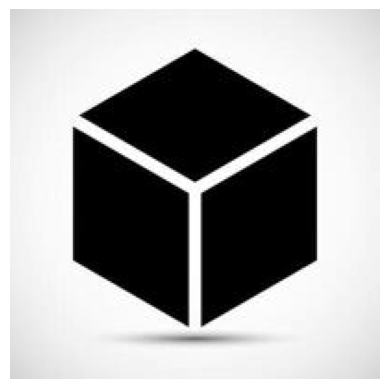

Dimenzije slike: (200, 200)


In [46]:
img = Image.open("data/exemple.jpg").convert("L")  # "L" = grayscale

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

img_array = np.array(img)
print("Dimenzije slike:", img_array.shape)


In [47]:
binary_matrix = np.where(img_array < 128, 1, 0)


print(binary_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [48]:
def init(binary_matrix1):
    rectangles = [] 
    H = len(binary_matrix1)         # broj redova
    W = len(binary_matrix1[0])      # broj kolona
    for i in range(H):
        for j in range(W):
            if binary_matrix1[i][j]:  # ako je 1, crni piksel
                rectangles.append([i, j, 1, 1])
    return rectangles, len(rectangles)


In [49]:
def calcSolutionValue(newRectangles):
    return len(newRectangles)

In [50]:
def merge_rect(R1, R2):
    x1, y1, h1, w1 = R1
    x2, y2, h2, w2 = R2
    x_new = min(x1, x2)
    y_new = min(y1, y2)
    h_new = max(x1+h1, x2+h2) - x_new
    w_new = max(y1+w1, y2+w2) - y_new
    return (x_new, y_new, h_new, w_new)

In [51]:
def can_merge(R1, R2, matrix):
    x1, y1, h1, w1 = R1
    x2, y2, h2, w2 = R2
    
    # horizontalno spajanje
    if x1 == x2 and h1 == h2:
        min_y = min(y1, y2)
        max_y = max(y1+w1, y2+w2)
        if np.all(matrix[x1:x1+h1, min_y:max_y]):
            return True
    # vertikalno spajanje
    if y1 == y2 and w1 == w2:
        min_x = min(x1, x2)
        max_x = max(x1+h1, x2+h2)
        if np.all(matrix[min_x:max_x, y1:y1+w1]):
            return True
    return False

In [73]:
def local_search():
    rectangles, currValue = init(binary_matrix)
    bestValue = currValue
    improved = True
    rectangles.sort(key=lambda r: (r[0], r[1]))

    while improved:
        improved = False

        for i in range(len(rectangles)):
            for j in range(i+1, min(i+50, len(rectangles))): # heuristika, provervamo samo bliske
                if can_merge(rectangles[i], rectangles[j],binary_matrix):
                    # spoji pravougaonike
                    new_rect = merge_rect(rectangles[i], rectangles[j])
                    
                    # kreiraj novu listu sa spojenim pravougaonikom
                    newRectangles = rectangles[:i] + rectangles[i+1:j] + rectangles[j+1:] + [new_rect]
                    
                    newValue = calcSolutionValue(newRectangles)

                    # prihvati samo ako je bolje
                    if newValue < currValue:
                        currValue = newValue
                        rectangles = newRectangles
                        improved = True
                        
                        if newValue < bestValue:
                            bestValue = newValue
                        
                        break  # primeni prvo poboljšanje i ponovi
            if improved:
                break
    
    return rectangles, bestValue

In [63]:
rectangles, bestValue = local_search()

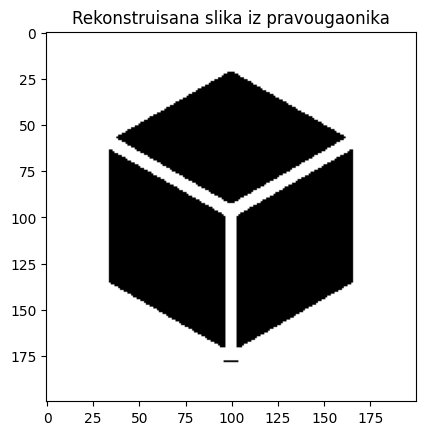

In [60]:
H, W = binary_matrix.shape

reconstructed = np.zeros((H, W), dtype=int)

for r in rectangles:
    x, y, h, w = r
    reconstructed[x:x+h, y:y+w] = 1  

plt.imshow(1 - reconstructed, cmap='gray')
plt.title("Rekonstruisana slika iz pravougaonika")
plt.show()

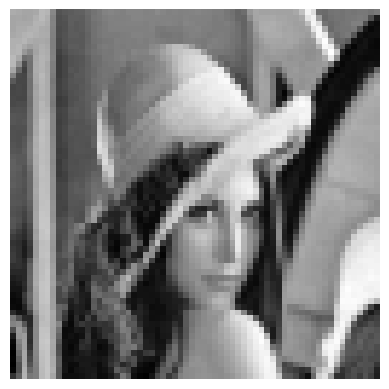

Dimenzije slike: (64, 64)


In [65]:
image = Image.open("data/example2.gif").convert("L")  # "L" = grayscale

image = image.resize((64, 64))

plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

image_array = np.array(image)
print("Dimenzije slike:", image_array.shape)

In [92]:
def init2(gray_matrix):
    rectangles = [] 
    H = len(gray_matrix)        
    W = len(gray_matrix[0])      
    for i in range(H):
        for j in range(W):
            val = gray_matrix[i][j]
            rectangles.append([i, j, 1, 1, val])
    return rectangles, len(rectangles)

In [105]:
def calcSolutionValue2(newRectangles, gray_matrix):
    H, W = gray_matrix.shape
    reconstructed = np.zeros((H, W))
    for x, y, h, w, v in newRectangles:
        reconstructed[x:x+h, y:y+w] = v
    return np.mean((gray_matrix - reconstructed) ** 2)

In [97]:
def merge_rect2(R1, R2):
    x1, y1, h1, w1, v1 = R1
    x2, y2, h2, w2, v2 = R2
    x_new = min(x1, x2)
    y_new = min(y1, y2)
    h_new = max(x1+h1, x2+h2) - x_new
    w_new = max(y1+w1, y2+w2) - y_new

    v_new = (v1 * h1 * w1 + v2 * h2 * w2) / (h1 * w1 + h2 * w2)
    
    return (x_new, y_new, h_new, w_new, v_new)

In [101]:
def can_merge2(R1, R2, gray_matrix, color_threshold=15):
    x1, y1, h1, w1, v1 = R1
    x2, y2, h2, w2, v2 = R2
    
    # Boje moraju biti dovoljno slične
    if abs(v1 - v2) > color_threshold:
        return False

    # Horizontalna susednost
    if x1 < x2 + h2 and x1 + h1 > x2:
        if y1 + w1 == y2 or y2 + w2 == y1:
            return True

    # Vertikalna susednost
    if y1 < y2 + w2 and y1 + w1 > y2:
        if x1 + h1 == x2 or x2 + h2 == x1:
            return True

    return False


In [99]:
def local_search2(gray_matrix):
    rectangles, currValue = init2(gray_matrix)
    bestValue = currValue
    improved = True
    rectangles.sort(key=lambda r: (r[0], r[1]))

    while improved:
        improved = False

        for i in range(len(rectangles)):
            for j in range(i+1, min(i+50, len(rectangles))): # heuristika, provervamo samo bliske
                if can_merge2(rectangles[i], rectangles[j],gray_matrix):
                    # spoji pravougaonike
                    new_rect = merge_rect2(rectangles[i], rectangles[j])
                    
                    # kreiraj novu listu sa spojenim pravougaonikom
                    newRectangles = rectangles[:i] + rectangles[i+1:j] + rectangles[j+1:] + [new_rect]
                    
                    newValue = calcSolutionValue2(newRectangles,gray_matrix)

                    # prihvati samo ako je bolje
                    if newValue < currValue:
                        currValue = newValue
                        rectangles = newRectangles
                        improved = True
                        
                        if newValue < bestValue:
                            bestValue = newValue
                        
                        break  # primeni prvo poboljšanje i ponovi
            if improved:
                break
    
    return rectangles, bestValue

In [5]:
import time

In [119]:
start = time.time()
rect_array, val = local_search2(image_array)
end = time.time()
print(f"Local search vreme: {end - start:.2f}s")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2472\2022900675.py:6: RuntimeWarning: overflow encountered in scalar subtract
  if abs(v1 - v2) > color_threshold:


Local search vreme: 6.42s


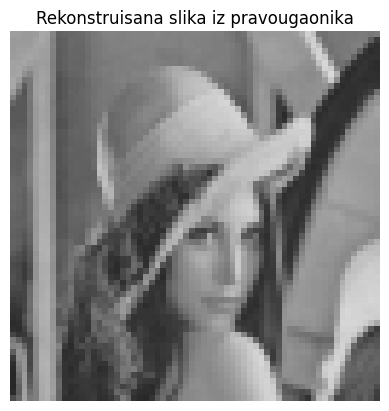

In [109]:
H, W = image_array.shape  
reconstructed = np.zeros((H, W))

for (x, y, h, w, v) in rect_array:
    reconstructed[x:x+h, y:y+w] = v  

plt.imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
plt.title("Rekonstruisana slika iz pravougaonika")
plt.axis('off')
plt.show()

In [3]:
import math, random

In [115]:
def local_search_sa(gray_matrix, T_start=1.0, T_end=1e-3, cooling=0.99):
    rectangles, currValue = init2(gray_matrix)
    best_rectangles = rectangles[:]
    bestValue = currValue

    T = T_start
    rectangles.sort(key=lambda r: (r[0], r[1]))

    while T > T_end:
        i = random.randint(0, len(rectangles) - 1)
        j = random.randint(i+1, min(i+50, len(rectangles)-1))
        
        if can_merge2(rectangles[i], rectangles[j], gray_matrix):
            new_rect = merge_rect2(rectangles[i], rectangles[j])
            newRectangles = rectangles[:i] + rectangles[i+1:j] + rectangles[j+1:] + [new_rect]
            newValue = calcSolutionValue2(newRectangles, gray_matrix)

            Δ = newValue - currValue
            if Δ < 0 or random.random() < math.exp(-Δ / T):  
                rectangles = newRectangles
                currValue = newValue

                if newValue < bestValue:
                    bestValue = newValue
                    best_rectangles = newRectangles[:]

        T *= cooling 

    return best_rectangles, bestValue


In [120]:
start = time.time()
rect_array, val = local_search_sa(image_array)
end = time.time()
print(f"Simulirano kaljenje vreme: {end - start:.2f}s")

Simulirano kaljenje vreme: 0.03s


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2472\2022900675.py:6: RuntimeWarning: overflow encountered in scalar subtract
  if abs(v1 - v2) > color_threshold:


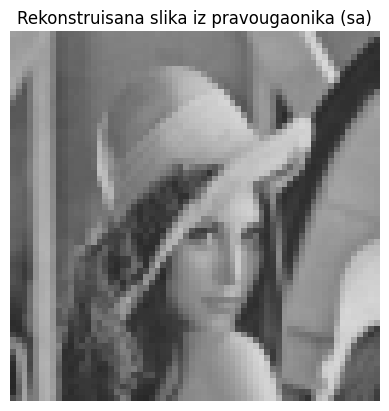

In [117]:
H, W = image_array.shape  
reconstructed = np.zeros((H, W))

for (x, y, h, w, v) in rect_array:
    reconstructed[x:x+h, y:y+w] = v  

plt.imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
plt.title("Rekonstruisana slika iz pravougaonika (sa)")
plt.axis('off')
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2472\2022900675.py:6: RuntimeWarning: overflow encountered in scalar subtract
  if abs(v1 - v2) > color_threshold:


Local search: vreme = 4464.63s, MSE = 0.00
Simulated annealing: vreme = 1.01s, MSE = 0.00


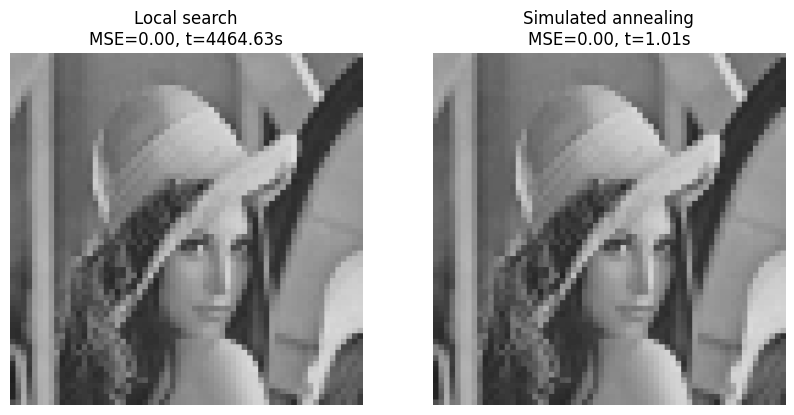

In [121]:
img = Image.open("data/example2.gif").convert("L") 
gray_matrix = np.array(img)

H, W = gray_matrix.shape

start = time.time()
rect_ls, mse_ls = local_search2(gray_matrix)
time_ls = time.time() - start

start = time.time()
rect_sa, mse_sa = local_search_sa(gray_matrix)
time_sa = time.time() - start

print(f"Local search: vreme = {time_ls:.2f}s, MSE = {mse_ls:.2f}")
print(f"Simulated annealing: vreme = {time_sa:.2f}s, MSE = {mse_sa:.2f}")


def reconstruct(rectangles, shape):
    H, W = shape
    reconstructed = np.zeros((H, W))
    for (x, y, h, w, v) in rectangles:
        reconstructed[x:x+h, y:y+w] = v
    return reconstructed

recon_ls = reconstruct(rect_ls, gray_matrix.shape)
recon_sa = reconstruct(rect_sa, gray_matrix.shape)


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(recon_ls, cmap='gray', vmin=0, vmax=255)
plt.title(f"Local search\nMSE={mse_ls:.2f}, t={time_ls:.2f}s")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(recon_sa, cmap='gray', vmin=0, vmax=255)
plt.title(f"Simulated annealing\nMSE={mse_sa:.2f}, t={time_sa:.2f}s")
plt.axis('off')

plt.show()

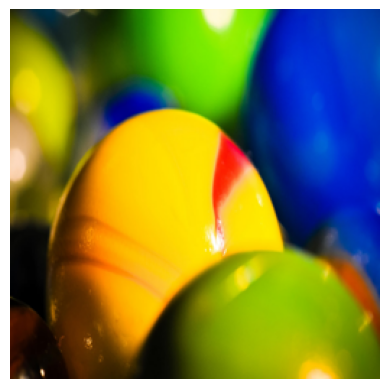

Dimenzije slike: (256, 256, 3)


In [116]:
image = Image.open("data/example3.jpg").convert("RGB")
image = image.resize((256, 256))

plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

image_array = np.array(image)
print("Dimenzije slike:", image_array.shape)

In [117]:
def init3(colored_matrix,block_size=2):
    rectangles = [] 
    H, W, _ = colored_matrix.shape
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            h = min(block_size, H - i)
            w = min(block_size, W - j)
            # prosečna boja bloka
            block = colored_matrix[i:i+h, j:j+w].astype(float)
            v = tuple(np.mean(block.reshape(-1, 3), axis=0))
            rectangles.append([i, j, h, w, v])
    return rectangles, len(rectangles)

In [118]:
def calcSolutionValue3(newRectangles, colored_matrix):
    H, W, _ = colored_matrix.shape
    reconstructed = np.zeros((H, W, 3), dtype=float)
    for x, y, h, w, c in newRectangles:
        reconstructed[x:x+h, y:y+w] = np.array(c, dtype=float)
    mse = np.mean((colored_matrix.astype(float) - reconstructed) ** 2)
    return mse

In [119]:
def merge_rect3(R1, R2):
    x1, y1, h1, w1, v1 = R1
    x2, y2, h2, w2, v2 = R2
    x_new = min(x1, x2)
    y_new = min(y1, y2)
    h_new = max(x1+h1, x2+h2) - x_new
    w_new = max(y1+w1, y2+w2) - y_new

    area1 = h1 * w1
    area2 = h2 * w2
    v_new = tuple(
        (v1[k] * area1 + v2[k] * area2) / (area1 + area2)
        for k in range(3)
    )
    
    return (x_new, y_new, h_new, w_new, v_new)

In [120]:
def can_merge3(R1, R2, colored_matrix, color_threshold=10):
    x1, y1, h1, w1, v1 = R1
    x2, y2, h2, w2, v2 = R2
    
    diff = np.linalg.norm(np.array(v1) - np.array(v2))
    if diff > color_threshold:
        return False

   

    # Horizontalna susednost
    if x1 < x2 + h2 and x1 + h1 > x2:
        if y1 + w1 == y2 or y2 + w2 == y1:
            return True

    # Vertikalna susednost
    if y1 < y2 + w2 and y1 + w1 > y2:
        if x1 + h1 == x2 or x2 + h2 == x1:
            return True

    return False

In [121]:
def local_search_sa_colored(colored_matrix, T_start=5.0, T_end=1e-2, cooling=0.995):
    rectangles, _ = init3(colored_matrix)
    currValue = calcSolutionValue3(rectangles, colored_matrix)
    best_rectangles = rectangles[:]
    bestValue = currValue

    T = T_start
    rectangles.sort(key=lambda r: (r[0], r[1]))

    while T > T_end:
        i = random.randint(0, len(rectangles) - 2)
        j = random.randint(i + 1, min(i + 10, len(rectangles) - 1))
        
        if can_merge3(rectangles[i], rectangles[j], colored_matrix):
            new_rect = merge_rect3(rectangles[i], rectangles[j])
            newRectangles = rectangles[:i] + rectangles[i+1:j] + rectangles[j+1:] + [new_rect]
            newValue = calcSolutionValue3(newRectangles, colored_matrix)

            Δ = newValue - currValue
            if Δ < 0 or random.random() < math.exp(-Δ / T):  
                rectangles = newRectangles
                currValue = newValue

                if newValue < bestValue:
                    bestValue = newValue
                    best_rectangles = newRectangles[:]

        T *= cooling 

    return best_rectangles, bestValue

In [122]:
start = time.time()
rect_array, val = local_search_sa_colored(image_array)
end = time.time()
print(f"Simulirano kaljenje vreme: {end - start:.2f}s")

Simulirano kaljenje vreme: 2.63s


In [123]:
def estimated_memory(rectangles):
    return len(rectangles) * 7 * 4

def evaluate_solution(rectangles, original_image):
    H, W, _ = original_image.shape
    reconstructed = np.zeros((H, W, 3), dtype=np.uint8)
    for x, y, h, w, c in rectangles:
        reconstructed[x:x+h, y:y+w] = np.array(c, dtype=np.uint8)
    
    mse = np.mean((original_image.astype(float) - reconstructed.astype(float))**2)
    memory = estimated_memory(rectangles)
    return mse, memory, reconstructed

In [124]:
mse_sa, mem_sa, recon_sa = evaluate_solution(rect_array, image_array)
print(f"Simulirano kaljenje: MSE={mse_sa:.2f}, Memorija={mem_sa/1024:.2f} KB")

Simulirano kaljenje: MSE=21.01, Memorija=448.00 KB


In [125]:
def RVNS_colored(colored_matrix, iters=5000, max_k=5, color_threshold=30):
    rectangles, _ = init3(colored_matrix)
    currValue = calcSolutionValue3(rectangles, colored_matrix)
    best_rectangles = rectangles[:]
    bestValue = currValue

    H, W, _ = colored_matrix.shape

    for iteration in range(iters):
        k = 0
        while k <= max_k:
            
            indices = random.sample(range(len(rectangles)), min(k+1, len(rectangles)))
            merged = False

            for i in range(len(indices)):
                for j in range(i+1, len(indices)):
                    if can_merge3(rectangles[indices[i]], rectangles[indices[j]], colored_matrix, color_threshold=color_threshold):
                        new_rect = merge_rect3(rectangles[indices[i]], rectangles[indices[j]])
                        newRectangles = [r for idx,r in enumerate(rectangles) if idx not in (indices[i], indices[j])] + [new_rect]
                        newValue = calcSolutionValue3(newRectangles, colored_matrix)

                        if newValue < currValue:
                            rectangles = newRectangles
                            currValue = newValue
                            merged = True
                            if newValue < bestValue:
                                bestValue = newValue
                                best_rectangles = newRectangles[:]
                            break
                if merged:
                    break

            if not merged:
                k += 1  

    return best_rectangles, bestValue


In [126]:
start = time.time()
rect_array, val = RVNS_colored(image_array)
end = time.time()
print(f"RVNS vreme: {end - start:.2f}s")

RVNS vreme: 3.27s


In [127]:
def estimated_memory(rectangles):
    return len(rectangles) * 7 * 4

def evaluate_solution(rectangles, original_image):
    H, W, _ = original_image.shape
    reconstructed = np.zeros((H, W, 3), dtype=np.uint8)
    for x, y, h, w, c in rectangles:
        reconstructed[x:x+h, y:y+w] = np.array(c, dtype=np.uint8)
    
    mse = np.mean((original_image.astype(float) - reconstructed.astype(float))**2)
    memory = estimated_memory(rectangles)
    return mse, memory, reconstructed

In [128]:
mse_sa, mem_sa, recon_sa = evaluate_solution(rect_array, image_array)
print(f"RVNS: MSE={mse_sa:.2f}, Memorija={mem_sa/1024:.2f} KB")

RVNS: MSE=21.01, Memorija=448.00 KB


MSE = 21.01


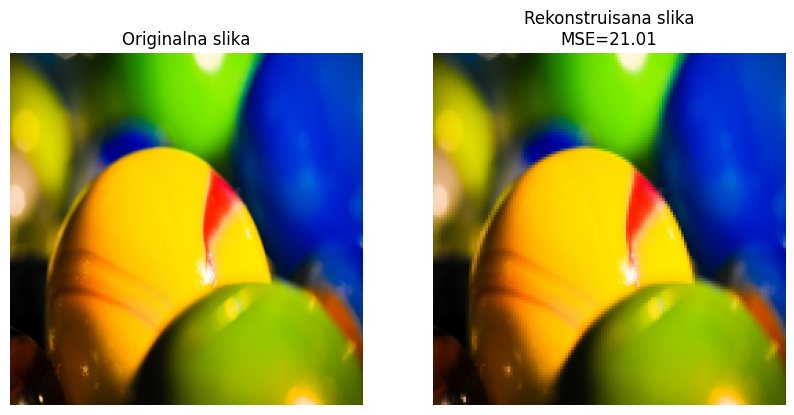

In [129]:
def reconstruct_colored(rectangles, shape):
    H, W, _ = shape
    reconstructed = np.zeros((H, W, 3), dtype=np.uint8)
    for (x, y, h, w, c) in rectangles:
        reconstructed[x:x+h, y:y+w] = np.array(c, dtype=np.uint8)
    return reconstructed


recon_img = reconstruct_colored(rect_array, image_array.shape)


mse = np.mean((image_array.astype(float) - recon_img.astype(float))**2)
print(f"MSE = {mse:.2f}")

# prikaži original i rekonstruisanu sliku
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image_array)
plt.title("Originalna slika")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(recon_img)
plt.title(f"Rekonstruisana slika\nMSE={mse:.2f}")
plt.axis('off')

plt.show()